In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from snorkel import SnorkelSession

session = SnorkelSession()

In [4]:
from snorkel.models import Candidate, candidate_subclass
REGULATOR = candidate_subclass('REGULATOR', ['Chemical', 'Gene'])

train = session.query(REGULATOR).filter(REGULATOR.split == 0).all()
dev = session.query(REGULATOR).filter(REGULATOR.split == 1).all()
test = session.query(REGULATOR).filter(REGULATOR.split == 2).all()
unlab = session.query(REGULATOR).filter(REGULATOR.split == 3).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))
print('Test set:\t{0} candidates'.format(len(unlab)))

Training set:	12968 candidates
Dev set:	3237 candidates
Test set:	8278 candidates
Test set:	79460 candidates


In [10]:
from snorkel.annotations import load_marginals
# train_marginals = load_marginals(session, split=0)
unlab_marginals = load_marginals(session, split=3)

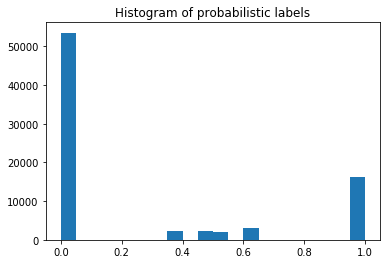

In [11]:
import matplotlib.pyplot as plt
plt.hist(unlab_marginals, bins=20)
plt.title('Histogram of probabilistic labels')
plt.show()

In [7]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [12]:
from snorkel.learning import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 1
}

lstm = reRNN(seed=1701, n_threads=None,)
lstm.train(unlab, unlab_marginals, X_dev=dev, Y_dev=L_gold_dev, **train_kwargs)

/home/antonis/anaconda2/envs/python27/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=77579  #epochs=5  batch size=256
[reRNN] Epoch 0 (351.03s)	Average loss=0.307127	Dev F1=56.84
[reRNN] Epoch 1 (710.37s)	Average loss=0.202439	Dev F1=58.19
[reRNN] Epoch 2 (1070.91s)	Average loss=0.168338	Dev F1=58.58
[reRNN] Epoch 3 (1432.59s)	Average loss=0.149154	Dev F1=59.22
[reRNN] Epoch 4 (1789.55s)	Average loss=0.140679	Dev F1=59.98
[reRNN] Model saved as <reRNN>
[reRNN] Training done (1793.63s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-4
[reRNN] Loaded model <reRNN>


# Check actual end-model score

In [13]:
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_test

<8278x1 sparse matrix of type '<type 'numpy.int64'>'
	with 8278 stored elements in Compressed Sparse Row format>

In [16]:
tp, fp, tn, fn = lstm.error_analysis(session, test, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.695
Neg. class accuracy: 0.769
Precision            0.487
Recall               0.695
F1                   0.572
----------------------------------------
TP: 1380 | FP: 1456 | TN: 4836 | FN: 606



In [27]:
from MLutils import F1_positive_class